In [1]:
from common import OUTPUTPATH
import data

import numpy as np
import os

coronas = sorted(data.corona_comp)
cores = sorted(data.core_comp)

monomer_crosstab = 0
for i in range(len(data.polymers)):
    monomer_crosstab += np.outer(data.polymers[coronas].iloc[i] > 0.5, data.polymers[cores].iloc[i] > 0.5)

monomer_crosstab

array([[  0,   0,   0,   0,   0,   0,   0,   8,   0,   0,   0,   0],
       [  0,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  22,   0,   0,   0,   0],
       [  0,  57,   0,   0,   0,   0,   0,   0,   0,   7,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  47,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 16,   0,   0,   0,  15,   6,   7, 167,  26,   0,  25,   0],
       [  0,   0,   0,   0,   0,   0,   0,  11,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   5,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   6,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  14,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   6,   0,   0,   0,   6,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  49,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  42,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  

In [2]:
# coronas = sorted(data.corona_comp)
# cores = sorted(data.core_comp)

# monomer_crosstab = 0
# for i in range(len(data.polymers)):
#     monomer_crosstab += np.outer(data.polymers[coronas].iloc[i], data.polymers[cores].iloc[i])

In [3]:
import pandas as pd
pd.crosstab([data.polymers['sphere'], data.polymers['other']], [data.polymers['worm'], data.polymers['vesicle']])


worm            0        1    
vesicle         0    1   0   1
sphere other                  
0      0       21  103  88  47
       1       11    0   3   1
1      0      242   15  54   7

In [4]:
target_counts = data.polymers[data.targets].replace(-1, 0).sum(axis=0).astype(np.int64)
target_counts

sphere     318
worm       200
vesicle    173
other       15
dtype: int64

In [5]:
def succ(bitlist):
    res = bitlist[:]
    i = len(res) - 1
    while res[i] == 1:
        res[i] = -1
        i -= 1
    res[i] = 1
    return res

def lexorder_bitlists(n):
    current = [-1]*n
    last = [1]*n
    res = [current]
    while current!=last:
        current = succ(current)
        res += [current]
    return res    

def label(bitlist):
    return ' '.join([data.targets[i][:1] if bitlist[i]==1 else ' ' for i in range(4)])

def ind_prob(bitlist):
    p = 1
    for i in range(len(bitlist)):
        p*=(data.polymers[data.targets[i]].values == bitlist[i]).sum()/len(data.polymers)
    return p

def prob_and_inf_table(order):
    ids = set(data.polymers.index)
    counts = np.zeros(shape=(16, 1), dtype=np.int64) 
    probs = np.zeros(shape=(16, 2))
    infs = np.zeros(shape=(16, 2))
    for i in range(len(order)):
        current = order[i]
        ids = ids - set(data.polymers[(data.polymers[data.targets] == current).all(axis=1)].index)
        count = (data.polymers[data.targets] == current).all(axis=1).sum()
        joint = count/len(data.polymers)
        ind = ind_prob(current)
        counts[i, 0] = count
        probs[i, 0] = joint
        probs[i, 1] = ind
        infs[i, 0] = -joint*(np.log2(joint)) if joint > 0 else 0
        infs[i, 1] = -joint*(np.log2(ind)) if joint > 0 else 0
    if ids: print('WARNING: ids',ids, 'remained unprocessed')
    return counts, probs, infs

size_based_order = np.array([[0, 0, 0, 0],
                    [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1],
                    [1, 1, 0, 0], [1, 0, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 1, 0, 1], [0, 0, 1, 1],
                    [1, 1, 1, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 1],
                    [1, 1, 1, 1]])
morph_count_table, morph_prob_table, morph_inf_table = prob_and_inf_table(size_based_order)
# morph_prob_table.round(decimals=3)

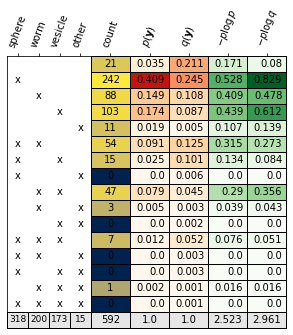

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

prob_colors = cm.get_cmap('OrRd')
# normalised = mpl.colors.LogNorm(0.000001, 0.5, True)
normalised = mpl.colors.Normalize(0.0, 0.5, True)
norm = normalised(morph_prob_table)

inf_colors = cm.get_cmap('Greens')
inf_normalised = mpl.colors.Normalize(0, 0.9, True)
inf_norm = inf_normalised(morph_inf_table)

count_colors = cm.get_cmap('cividis')
count_normalised = mpl.colors.LogNorm(0.000001, 258, True)
count_norm = count_normalised(morph_count_table).data

target_counts = data.polymers[data.targets].replace(-1, 0).sum(axis=0).astype(np.int64)

def plot_morphology_prob_table(ax=None):
    ax = ax if ax is not None else plt.gca()
    h_mt = 16/17 # main table height
    
    symb = np.vectorize(lambda x: 'x' if x==1 else ' ')
    ax.table(cellText=np.array(symb(size_based_order)), bbox=[0, 1-h_mt, 0.3, h_mt], cellLoc='center', edges='open')
    ax.table(cellText=morph_count_table, cellLoc='center', cellColours=count_colors(count_norm), bbox=[0.3, 1-h_mt, 0.7/5, h_mt], edges='closed')
    ax.table(cellText=morph_prob_table.round(decimals=3), cellColours=prob_colors(norm.data), loc='center', bbox=[0.3+0.7/5, 1-h_mt, 2*0.7/5, h_mt], edges='closed')
    ax.table(cellText=morph_inf_table.round(decimals=3), cellColours=inf_colors(inf_norm.data), loc='center', bbox=[0.3+3*0.7/5, 1-h_mt, 1-0.3-3*0.7/5, h_mt], edges='closed')

    sums = [morph_count_table.sum()]+list(morph_prob_table.sum(axis=0).round(decimals=2))+list(morph_inf_table.sum(axis=0).round(decimals=3))
    ax.table(cellText=[[str(c) for c in target_counts]], cellColours=[[cm.gray(0.9)]*4], bbox=[0, 0, 0.3, 1/17], cellLoc='center', edges='closed')
    ax.table(cellText=[sums], cellColours=[[cm.gray(0.9)]*5], bbox=[0.3, 0, 0.7, 1/17], cellLoc='center', edges='closed')

    ax.xaxis.set_tick_params(rotation=70)
    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator([0.3/8+0.3*i/4 for i in range(4)]+[0.3+0.7/10+i*0.7/5 for i in range(5)]))
    ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter(data.targets+['count', r'$p(\mathbf{y})$', r'$q(\mathbf{y})$', '$-p \log p$', '$-p \log q$']))
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.tick_params(axis='y', left=False, labelleft=False)

fig, ax = plt.subplots(figsize=(5, 5))
plot_morphology_prob_table()


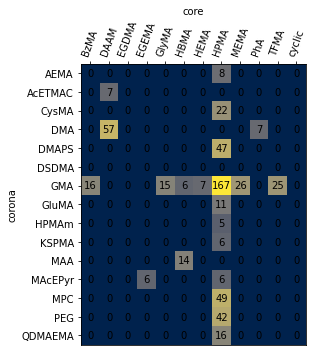

In [7]:
def plot_monomer_crosstab(crosstab, ax=None):
    ax = ax if ax is not None else plt.gca()
    ax.matshow(np.log2(crosstab+1), cmap='cividis')
    for i in range(len(cores)):
        for j in range(len(coronas)):
            c = crosstab[j,i]
            ax.text(i, j, str(round(c)), va='center', ha='center')

    ax.xaxis.set_tick_params(rotation=70)
    ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(range(len(cores))))
    ax.xaxis.set_major_formatter(mpl.ticker.FixedFormatter([s[5:] for s in cores]))
    ax.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.set_xlabel('core')
    ax.set_ylabel('corona')
    ax.xaxis.set_label_position('top')

    ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(range(len(coronas))))
    ax.yaxis.set_major_formatter(mpl.ticker.FixedFormatter([s[7:] for s in coronas]))

fig, ax = plt.subplots(figsize=(5, 5))
plot_monomer_crosstab(monomer_crosstab)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTPATH, 'monomer_counts.pdf'))
plt.show()

In [8]:
data.x[(data.x.core_HEMA==1) & (data.x.corona_GMA==1)].shape

(7, 50)

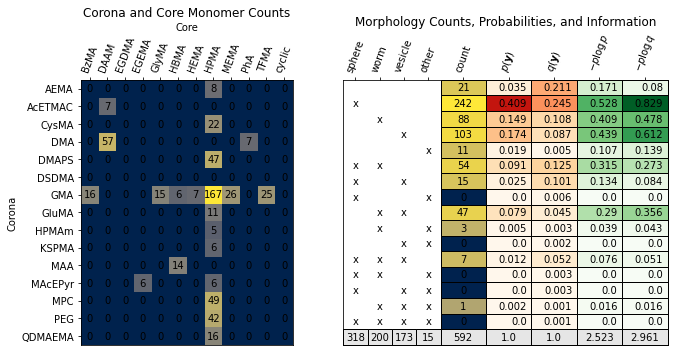

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
plot_monomer_crosstab(monomer_crosstab, ax1)
plot_morphology_prob_table(ax2)
ax1.set_ylabel('Corona')
ax1.set_xlabel('Core')
ax1.set_title('Corona and Core Monomer Counts')
ax2.set_title('Morphology Counts, Probabilities, and Information')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUTPATH, 'combined_monomer_morphology_counts.pdf'))
plt.show()


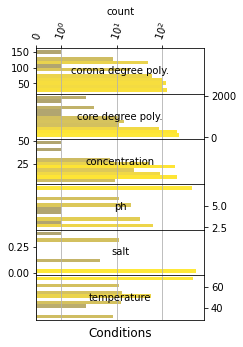

In [10]:
def plot_conditions(fig):
    axs = fig.subplots(6, 1, sharex=True)

    def plot_colored_hist(ax, data, label=None):
        N, bins, patches = ax.hist(data, bins=12, orientation='horizontal')
        ax.set_xscale('symlog')
        cols = count_colors(count_normalised(N))
        for _patch, _col in zip(patches, cols):
            _patch.set_facecolor(_col)
        ax.annotate(data.name if label is None else label, (0.5, 0.5), xycoords='axes fraction', va='center', ha='center')
        ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False, labeltop=False)
        ax.grid(True, 'major', axis='x')

    plot_colored_hist(axs[0], data.polymers.dp_corona, 'corona degree poly.')
    plot_colored_hist(axs[1], data.polymers.dp_core, 'core degree poly.')
    plot_colored_hist(axs[2], data.polymers.conc, 'concentration')
    plot_colored_hist(axs[3], data.polymers.ph)
    plot_colored_hist(axs[4], data.polymers.salt)
    plot_colored_hist(axs[5], data.polymers.temp, 'temperature')
    axs[0].xaxis.set_tick_params(rotation=70)
    axs[0].tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    axs[1].tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
    axs[3].tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
    axs[5].tick_params(axis='y', left=False, right=True, labelleft=False, labelright=True)
    fig.subplots_adjust(hspace=0.0)
    axs[5].set_title('Conditions', y=-0.5)
    axs[0].set_xlabel('count')
    axs[0].xaxis.set_label_position('top')

fig = plt.figure(figsize=(3, 5))
plot_conditions(fig)
plt.show()

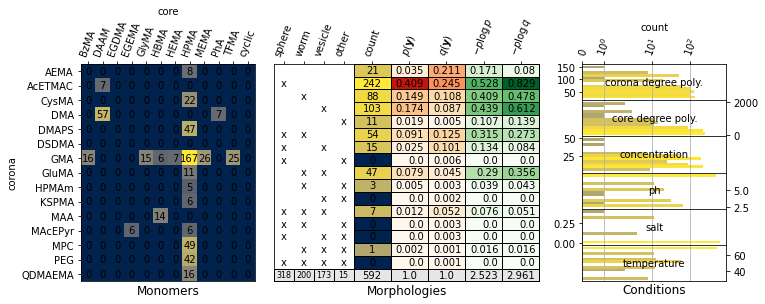

In [11]:
fig = plt.figure(constrained_layout=False, figsize=(12, 4))
subfigs = fig.subfigures(1, 2, wspace=0.0, width_ratios=[10, 2])

axs_left = subfigs[0].subplots(1, 2)
plot_monomer_crosstab(monomer_crosstab, axs_left[0])
plot_morphology_prob_table(axs_left[1])

axs_left[0].set_title('Monomers', y=-0.085)
axs_left[1].set_title('Morphologies', y=-0.085)
subfigs[0].subplots_adjust(left=0, wspace=-0.1, right=0.7)
subfigs[1].subplots_adjust(left=-1.2, right=-0.2)

plot_conditions(subfigs[1])
plt.savefig(os.path.join(OUTPUTPATH, 'monomer_morphology_conditions.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()